# Imports

In [1]:
import os
import cv2
import numpy as np
from pathlib import Path

os.chdir(Path().resolve().parent)

from src.data_processing.visualization import (
    process_training_ct_scan_metadata,
    process_test_ct_scan_metadata,
    visualize_segmentation_from_numpy_arrays,
    generate_sweetviz_report,
)
from src.data_processing.preprocessing import (
    apply_preprocessing_to_input_image,
    apply_preprocessing_to_label_mask,
    get_bounding_boxes,
)

from src.data_processing.loader import SAMSegmentationDataset, create_dataloader
from src.modeling.trainer import SAMTrainer
from src.modeling.inference import run_SAM_inference_and_save_masks

# Exploratory Data Analysis

## Process Datasets Metadata

In [2]:
# Slice level Information
train_data = process_training_ct_scan_metadata(
    train_images_directory="data/train_images/",
    train_labels_directory="data/train_labels/",
    spacing_file_path="data/metadata/spacing_mm.txt",
)

train_data.head(5)

,CT_ID,slice_count,data_split_type,spacing_X,spacing_Y,spacing_Z,slice_id,num_organs,Gallbladder,Stomach,Esophagus,Right Kidney,Right Adrenal Gland,Left Adrenal Gland,Liver,Left Kidney,Aorta,Spleen,Inferior Vena Cava,Pancreas
0,01,129,train,0.976562,0.976562,2.5,1,1,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0022,0.0000,0.0000,0.0000,0.0
1,01,129,train,0.976562,0.976562,2.5,10,1,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0101,0.0000,0.0000,0.0000,0.0
2,01,129,train,0.976562,0.976562,2.5,100,6,0.0,0.0042,0.0006,0.0,0.0,0.0,0.0784,0.0000,0.0018,0.0339,0.0019,0.0
3,01,129,train,0.976562,0.976562,2.5,101,6,0.0,0.0012,0.0007,0.0,0.0,0.0,0.0725,0.0000,0.0017,0.0319,0.0028,0.0
4,01,129,train,0.976562,0.976562,2.5,102,5,0.0,0.0000,0.0008,0.0,0.0,0.0,0.0623,0.0000,0.0018,0.0300,0.0026,0.0


In [3]:
# Test no labels, hence CT level information
test_data = process_test_ct_scan_metadata(
    test_images_directory="data/test_images/",
    spacing_file_path="data/metadata/spacing_mm.txt",
)

test_data.head(5)

,CT_ID,slice_count,data_split_type,spacing_X,spacing_Y,spacing_Z
0,51,54,test,0.769531,0.769531,5.0
1,52,94,test,0.769531,0.769531,2.5
2,53,68,test,0.683594,0.683594,3.0
3,54,101,test,0.644531,0.644531,2.5
4,55,93,test,0.863281,0.863281,2.5


## Visualization of Labels
Here are the organs and their color:
| Label | Organ                  | Color            |
|-------|------------------------|------------------|
| 0     | Background             | Black            |
| 1     | Gallbladder            | Yellow           |
| 2     | Stomach                | Red              |
| 3     | Esophagus              | Green            |
| 4     | Right Kidney           | Blue             |
| 5     | Right Adrenal Gland    | Orange           |
| 6     | Left Adrenal Gland     | Purple           |
| 7     | Liver                  | Magenta          |
| 8     | Left Kidney            | Cyan             |
| 9     | Aorta                  | Pink             |
| 10    | Spleen                 | Dark Green       |
| 11    | Inferior Vena Cava     | Gray             |
| 12    | Pancreas               | Dark Blue        |


In [4]:
image = cv2.imread("data/train_images/33/15.png", cv2.IMREAD_GRAYSCALE)
mask = cv2.imread("data/train_labels/33/15.png", cv2.IMREAD_GRAYSCALE)

Labels in segmentation mask and corresponding organs:
Label 0: Background
Label 4: Right Kidney
Label 7: Liver
Label 9: Aorta
Label 11: Inferior Vena Cava


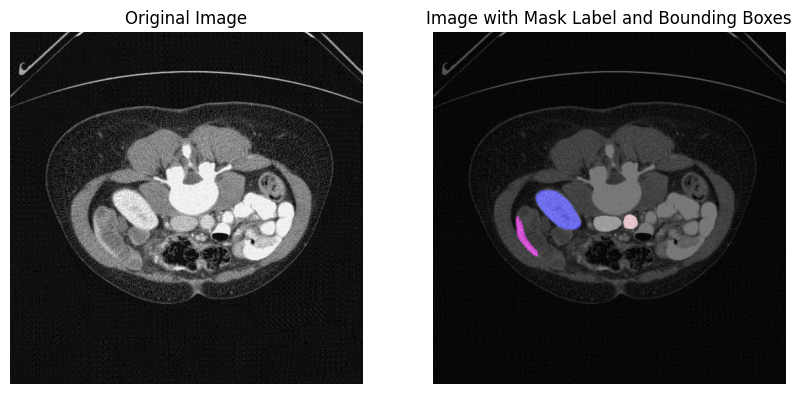

In [5]:
visualize_segmentation_from_numpy_arrays(image, mask)

## Sweetviz EDA Visualization

Output saved to results folder.


In [6]:
generate_sweetviz_report(
    train_data, report_filename="results/EDA/train_data_EDA_report.html"
)

                                             |          | [  0%]   00:00 -> (? left)

Report results/EDA/train_data_EDA_report.html was generated.


In [7]:
generate_sweetviz_report(
    test_data, report_filename="results/EDA/test_data_EDA_report.html"
)

                                             |          | [  0%]   00:00 -> (? left)

Report results/EDA/test_data_EDA_report.html was generated.


# Data Preprocessing

Just a sample of the data preprocessing.

In [8]:
new_image = apply_preprocessing_to_input_image(image)

In [9]:
bounding_boxes_dict = get_bounding_boxes(mask, "33", 15)
list_of_bounding_boxes = [bounding_box for _, bounding_box in bounding_boxes_dict.items()]

Labels in segmentation mask and corresponding organs:
Label 0: Background
Label 4: Right Kidney
Label 7: Liver
Label 9: Aorta
Label 11: Inferior Vena Cava


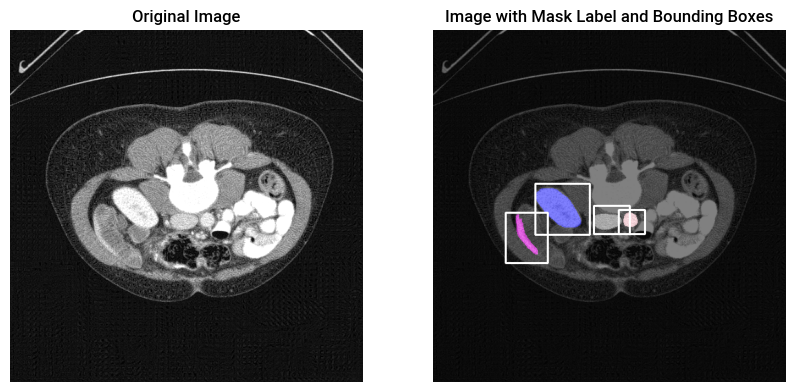

In [10]:
visualize_segmentation_from_numpy_arrays(new_image, mask, list_of_bounding_boxes)

# Modeling

In [11]:
# Transfer Learning by loading pretrained weights
pretrained_model_name = "wanglab/medsam-vit-base"

## Prepare the Dataset

In [12]:
train_dataset = SAMSegmentationDataset(
    image_dir="data/train_images",
    mask_dir="data/train_labels",
    spacing_metadata_dir="data/metadata/spacing_mm.txt",
    processor=pretrained_model_name,
)

print(f"Number of records: {len(train_dataset)}")
print(f"Example of one record:")
for k, v in train_dataset[0].items():
    print(f"{k}: {v.shape}")

Number of records: 22484
Example of one record:
pixel_values: torch.Size([3, 1024, 1024])
original_sizes: torch.Size([2])
reshaped_input_sizes: torch.Size([2])
input_boxes: torch.Size([1, 4])
ground_truth_mask: torch.Size([512, 512])


In [13]:
test_dataset = SAMSegmentationDataset(
    image_dir="data/test_images",
    bbox_file_dir="data/metadata/test1_bbox.txt",
    spacing_metadata_dir="data/metadata/spacing_mm.txt",
    processor=pretrained_model_name,
)

print(f"Number of records: {len(test_dataset)}")
print(f"Example of one record:")
for k, v in test_dataset[0].items():
    try:
        print(f"{k}: {v.shape}")
    except:
        print(f"{k}: {v}")

Number of records: 6543
Example of one record:
pixel_values: torch.Size([3, 1024, 1024])
original_sizes: torch.Size([2])
reshaped_input_sizes: torch.Size([2])
input_boxes: torch.Size([1, 4])
image_path: data/test_images\51\1.png


In [14]:
train_dataloader = create_dataloader(
    train_dataset,
    batch_size=36,
    train_ratio=0.8,
    shuffle=True,
    num_workers=2,
)

In [15]:
batch = next(iter(train_dataloader))

print(f"Example of one batch:")
for k, v in batch.items():
    print(f"{k}: {v.shape}")

Example of one batch:
pixel_values: torch.Size([36, 3, 1024, 1024])
original_sizes: torch.Size([36, 2])
reshaped_input_sizes: torch.Size([36, 2])
input_boxes: torch.Size([36, 1, 4])
ground_truth_mask: torch.Size([36, 512, 512])


## Train the Model

In [16]:
trainer = SAMTrainer(
    model_name=pretrained_model_name,
    device="cpu",  # Use GPU (cuda) if available
    learning_rate=1e-5,
    weight_decay=0,
)
print(trainer.model)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [17]:
# model.k_fold_cross_validation(
#     dataloader=train_dataloader,  # SAM DataLoader object
#     k_folds=5,  # Default: 5 folds
#     num_epochs=10,  # Default: 10 epochs per fold
# )

## Run Inference on Trained Model

In [18]:
# run_SAM_inference_and_save_masks(
#     model=trainer.model,
#     test_dataset=test_dataset,
#     batch_size=1,
#     device="cpu",
# )

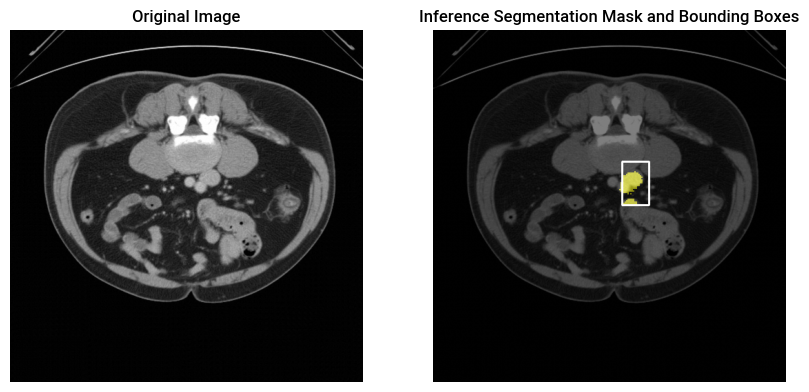

In [19]:
# I have only ran inference on only 3 slices
image = cv2.imread("data/test_images/51/1.png", cv2.IMREAD_GRAYSCALE)
mask = cv2.imread("data/test_labels/51/1.png", cv2.IMREAD_GRAYSCALE)

mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)
mask = (mask > 0).astype(np.uint8)

visualize_segmentation_from_numpy_arrays(image, mask, [[274, 192, 313, 255]], from_inference=True)